# Determine if ML clusters can help to predict log error

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.cluster import KMeans,FeatureAgglomeration
import scipy.stats as stats

from wrangle import wrangle_zillow_cluster
from env import get_db_url
import prep

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('zillow_clustering.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77380 entries, 0 to 77379
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77380 non-null  int64  
 1   parcelid                      77380 non-null  int64  
 2   airconditioningtypeid         24953 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77380 non-null  float64
 6   bedroomcnt                    77380 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49671 non-null  float64
 9   calculatedbathnbr             76771 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6023 non-null   float64
 12  calculatedfinishedsquarefeet  77184 non-null  float64
 13  f

In [3]:
clean_df = wrangle_zillow_cluster(df)

clean_df.info()

Reading from CSV file...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52215 entries, 0 to 77379
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   parcel_id         52215 non-null  int64  
 1   baths             52215 non-null  float64
 2   beds              52215 non-null  int64  
 3   bldg_qual         52215 non-null  int64  
 4   calc_bath         52215 non-null  float64
 5   calc_fin_sqft     52215 non-null  float64
 6   fin_sqft_12       52215 non-null  float64
 7   county_name       52215 non-null  object 
 8   full_bath_ct      52215 non-null  int64  
 9   heat_sys          52215 non-null  int64  
 10  lat               52215 non-null  float64
 11  long              52215 non-null  float64
 12  has_pool          52215 non-null  uint8  
 13  county_prop_code  52215 non-null  object 
 14  zip               52215 non-null  int64  
 15  room_ct           52215 non-null  int64  
 16  unit_ct        

In [4]:
clean_df.head()

,parcel_id,baths,beds,bldg_qual,calc_bath,calc_fin_sqft,fin_sqft_12,county_name,full_bath_ct,heat_sys,lat,long,has_pool,county_prop_code,zip,room_ct,unit_ct,has_firepl,tax_val,log_err,transact_date,heat_sys_desc,prop_land_desc,prop_age
0,14297519,3.5,4,6,3.5,3100.0,3100.0,Orange County,3,24,33634931.0,-117869207.0,0,122,96978,0,1,0,1023282.0,0.025595,2017-01-01,Yes,Single Family Residential,19
1,17052889,1.0,2,6,1.0,1465.0,1465.0,Ventura County,1,24,34449266.0,-119281531.0,0,1110,97099,5,1,0,464000.0,0.055619,2017-01-01,Yes,Single Family Residential,50
2,14186244,2.0,3,6,2.0,1243.0,1243.0,Orange County,2,24,33886168.0,-117823170.0,1,122,97078,6,1,0,564778.0,0.005383,2017-01-01,Yes,Single Family Residential,55
3,12177905,3.0,4,8,3.0,2376.0,2376.0,LA County,3,2,34245180.0,-118240722.0,1,0101,96330,0,1,0,145143.0,-0.103410,2017-01-01,Central,Single Family Residential,47
6,12095076,3.0,4,9,3.0,2962.0,2962.0,LA County,3,2,34145202.0,-118179824.0,1,0101,96293,0,1,0,773303.0,-0.001011,2017-01-01,Central,Single Family Residential,67


In [5]:
clean_df.columns

Index(['parcel_id', 'baths', 'beds', 'bldg_qual', 'calc_bath', 'calc_fin_sqft',
       'fin_sqft_12', 'county_name', 'full_bath_ct', 'heat_sys', 'lat', 'long',
       'has_pool', 'county_prop_code', 'zip', 'room_ct', 'unit_ct',
       'has_firepl', 'tax_val', 'log_err', 'transact_date', 'heat_sys_desc',
       'prop_land_desc', 'prop_age'],
      dtype='object')

In [6]:
clean_df.isna().sum()


parcel_id           0
baths               0
beds                0
bldg_qual           0
calc_bath           0
calc_fin_sqft       0
fin_sqft_12         0
county_name         0
full_bath_ct        0
heat_sys            0
lat                 0
long                0
has_pool            0
county_prop_code    0
zip                 0
room_ct             0
unit_ct             0
has_firepl          0
tax_val             0
log_err             0
transact_date       0
heat_sys_desc       0
prop_land_desc      0
prop_age            0
dtype: int64

In [7]:
clean_df.describe()

,parcel_id,baths,beds,bldg_qual,calc_bath,calc_fin_sqft,fin_sqft_12,full_bath_ct,heat_sys,lat,long,has_pool,zip,room_ct,unit_ct,has_firepl,tax_val,log_err,prop_age
count,5.221500e+04,52215.000000,52215.000000,52215.000000,52215.000000,52215.000000,52215.000000,52215.000000,52215.000000,5.221500e+04,5.221500e+04,52215.000000,52215.000000,52215.000000,52215.000000,52215.000000,5.221500e+04,52215.000000,52215.000000
mean,1.295436e+07,2.300010,3.301542,6.171119,2.304070,1922.252667,1923.899550,2.238935,11.039644,3.402242e+07,-1.181938e+08,0.211836,96636.677870,1.896160,1.000498,0.001551,5.283295e+05,0.018189,53.565163
std,2.178432e+06,1.021509,0.946446,1.381718,1.016095,1002.419910,1000.814076,0.991277,9.794596,2.741643e+05,3.566395e+05,0.408613,4613.838217,3.147925,0.023152,0.039356,7.465798e+05,0.176522,23.083161
min,1.071186e+07,0.000000,0.000000,1.000000,1.000000,128.000000,128.000000,1.000000,1.000000,3.334062e+07,-1.194753e+08,0.000000,95982.000000,0.000000,1.000000,0.000000,3.254000e+03,-4.655420,1.000000
25%,1.150903e+07,2.000000,3.000000,6.000000,2.000000,1268.000000,1272.000000,2.000000,2.000000,3.382676e+07,-1.184003e+08,0.000000,96206.000000,0.000000,1.000000,0.000000,1.939865e+05,-0.024615,38.000000
50%,1.257832e+07,2.000000,3.000000,6.000000,2.000000,1660.000000,1665.000000,2.000000,7.000000,3.402325e+07,-1.181529e+08,0.000000,96412.000000,0.000000,1.000000,0.000000,3.734800e+05,0.006956,56.000000
75%,1.413002e+07,3.000000,4.000000,7.000000,3.000000,2304.000000,2303.000000,3.000000,24.000000,3.418729e+07,-1.179289e+08,0.000000,96995.000000,5.000000,1.000000,0.000000,6.185360e+05,0.040588,67.000000
max,1.629608e+08,18.000000,14.000000,12.000000,18.000000,21929.000000,21929.000000,18.000000,24.000000,3.481877e+07,-1.175546e+08,1.000000,399675.000000,15.000000,3.000000,1.000000,4.906124e+07,5.262999,139.000000


In [8]:
clean_df.county_name.value_counts()

LA County         33742
Orange County     14100
Ventura County     4373
Name: county_name, dtype: int64

In [9]:
clean_df.prop_land_desc.value_counts()

Single Family Residential    52215
Name: prop_land_desc, dtype: int64

In [10]:
clean_df.county_prop_code.value_counts()

0100    26652
122     13036
0101     6384
1111     3346
1        1064
1110     1019
0104      367
010G       93
0103       90
0108       57
010M       52
0109       17
1112        8
0113        6
0110        6
0141        4
0102        3
0105        3
0111        2
0130        2
0133        1
0131        1
0115        1
0114        1
Name: county_prop_code, dtype: int64

In [11]:
clean_df = clean_df.drop(columns= ['county_prop_code', 'transact_date'])

clean_df.select_dtypes(exclude=np.number).columns

Index(['county_name', 'heat_sys_desc', 'prop_land_desc'], dtype='object')

<AxesSubplot:>

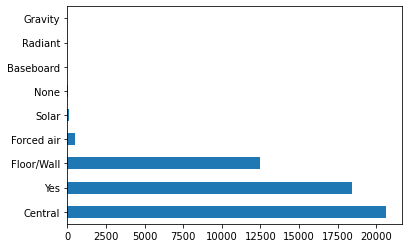

In [13]:
clean_df.heat_sys_desc.value_counts().plot.barh()


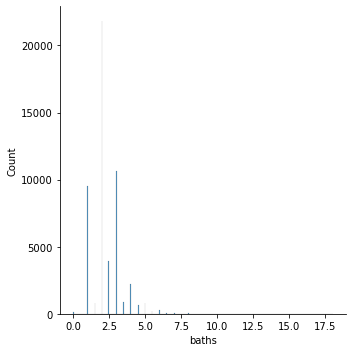

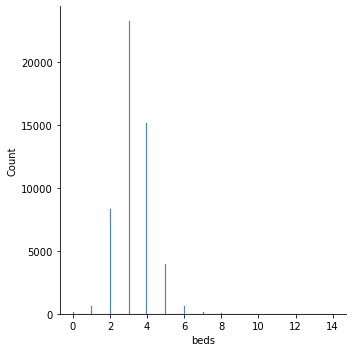

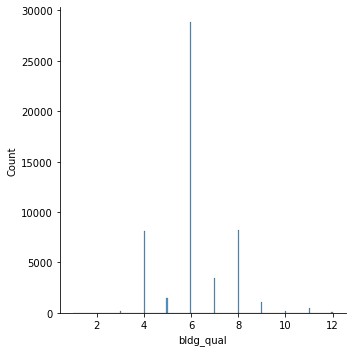

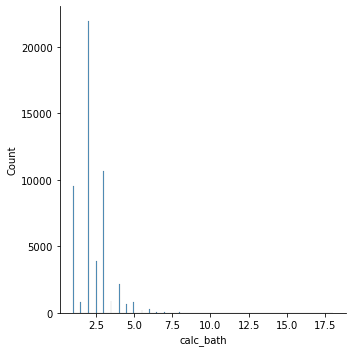

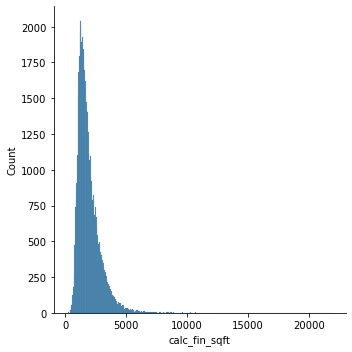

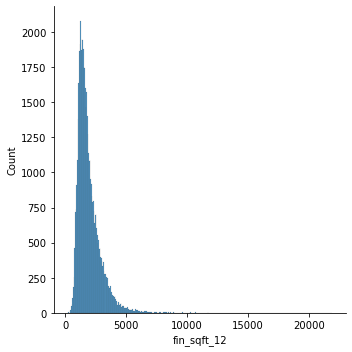

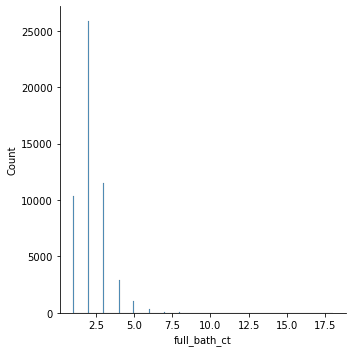

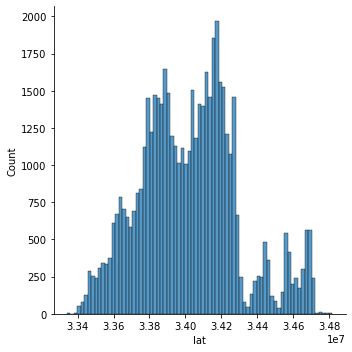

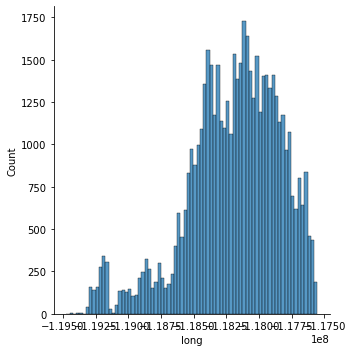

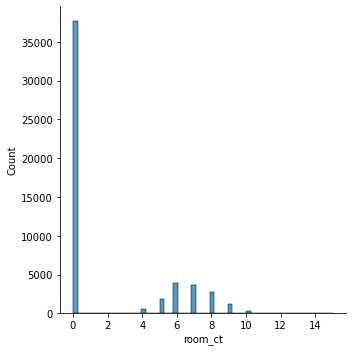

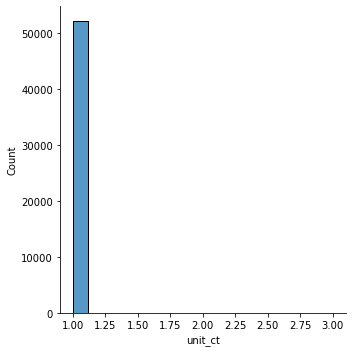

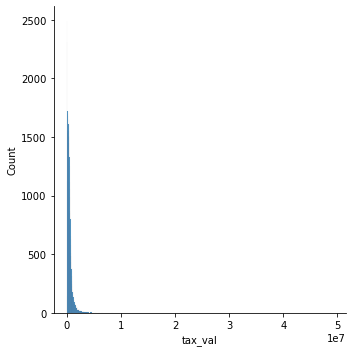

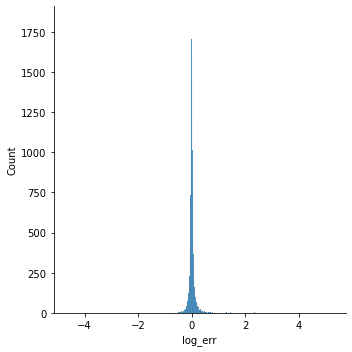

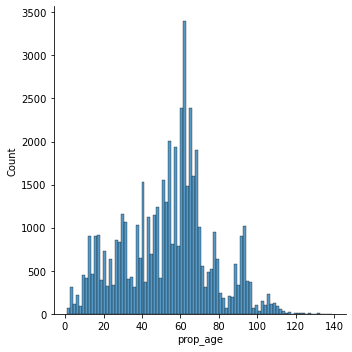

In [20]:
num_cols = clean_df.select_dtypes(include= (np.float64, np.int64)).columns.to_list()

num_cols.pop(0)

num_cols = ['baths',
 'beds',
 'bldg_qual',
 'calc_bath',
 'calc_fin_sqft',
 'fin_sqft_12',
 'full_bath_ct',
 'lat',
 'long',
 'room_ct',
 'unit_ct',
 'tax_val',
 'log_err',
 'prop_age'
 ]

for col in num_cols:
    sns.displot(clean_df[col])
    plt.show()

In [22]:
clean_df.room_ct.value_counts().sort_index()


0     37674
1         1
2        10
3        78
4       517
5      1884
6      3970
7      3606
8      2807
9      1170
10      338
11      108
12       35
13       10
14        6
15        1
Name: room_ct, dtype: int64

In [23]:
clean_df[clean_df.room_ct > 0].county_name.value_counts().sort_index()

Orange County     10200
Ventura County     4341
Name: county_name, dtype: int64

### Observation: "room count" ('room_ct') metric apparently not collected in LA County

### Takeaways: After adjusting for the outliers, the distributions of the numeric variables lat, long, yr_blt/prop_age, beds, baths, and finishedsquarefeet12/calculatedfinishedsquarefeet appear to be favorable for further manipulation and/or analysis. Other variables like has_pool and has_firepl come already onehot-encoded and could also be useful.

In [24]:
clean_df.info()
clean_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52215 entries, 0 to 77379
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   parcel_id       52215 non-null  int64  
 1   baths           52215 non-null  float64
 2   beds            52215 non-null  int64  
 3   bldg_qual       52215 non-null  int64  
 4   calc_bath       52215 non-null  float64
 5   calc_fin_sqft   52215 non-null  float64
 6   fin_sqft_12     52215 non-null  float64
 7   county_name     52215 non-null  object 
 8   full_bath_ct    52215 non-null  int64  
 9   heat_sys        52215 non-null  int64  
 10  lat             52215 non-null  float64
 11  long            52215 non-null  float64
 12  has_pool        52215 non-null  uint8  
 13  zip             52215 non-null  int64  
 14  room_ct         52215 non-null  int64  
 15  unit_ct         52215 non-null  int64  
 16  has_firepl      52215 non-null  uint8  
 17  tax_val         52215 non-null 

,parcel_id,baths,beds,bldg_qual,calc_bath,calc_fin_sqft,fin_sqft_12,county_name,full_bath_ct,heat_sys,lat,long,has_pool,zip,room_ct,unit_ct,has_firepl,tax_val,log_err,heat_sys_desc,prop_land_desc,prop_age
0,14297519,3.5,4,6,3.5,3100.0,3100.0,Orange County,3,24,33634931.0,-117869207.0,0,96978,0,1,0,1023282.0,0.025595,Yes,Single Family Residential,19
1,17052889,1.0,2,6,1.0,1465.0,1465.0,Ventura County,1,24,34449266.0,-119281531.0,0,97099,5,1,0,464000.0,0.055619,Yes,Single Family Residential,50
2,14186244,2.0,3,6,2.0,1243.0,1243.0,Orange County,2,24,33886168.0,-117823170.0,1,97078,6,1,0,564778.0,0.005383,Yes,Single Family Residential,55
3,12177905,3.0,4,8,3.0,2376.0,2376.0,LA County,3,2,34245180.0,-118240722.0,1,96330,0,1,0,145143.0,-0.103410,Central,Single Family Residential,47
6,12095076,3.0,4,9,3.0,2962.0,2962.0,LA County,3,2,34145202.0,-118179824.0,1,96293,0,1,0,773303.0,-0.001011,Central,Single Family Residential,67


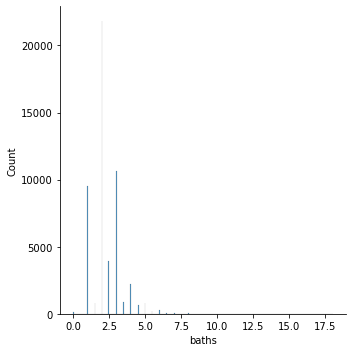

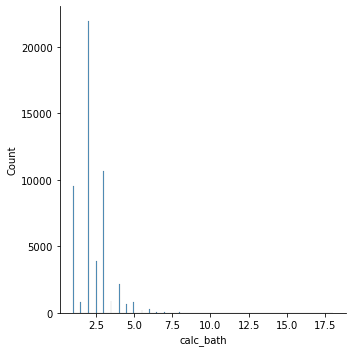

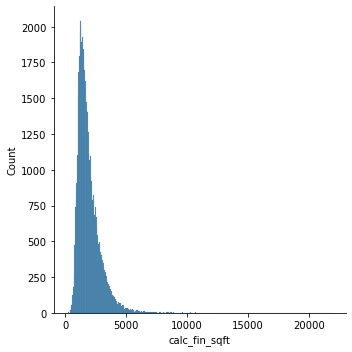

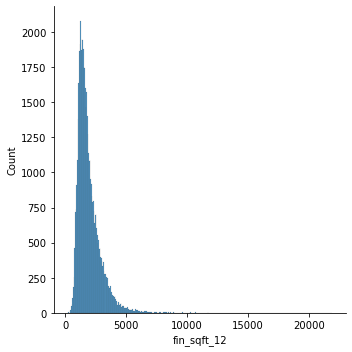

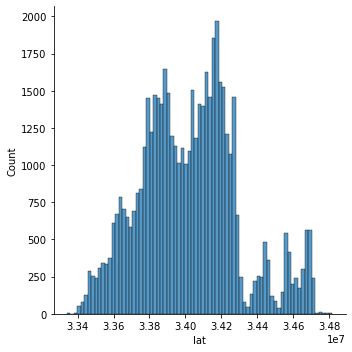

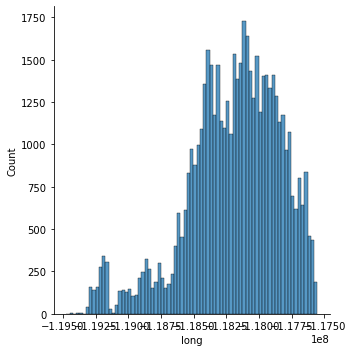

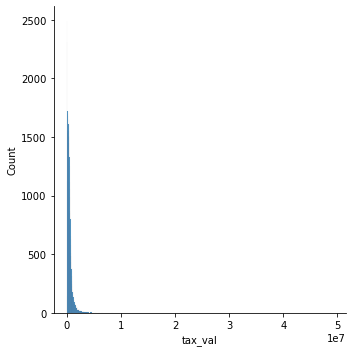

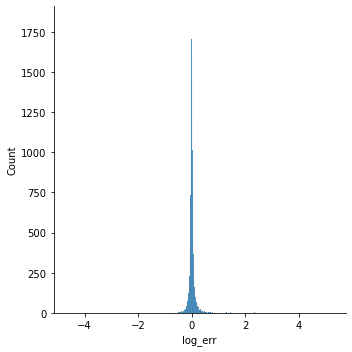

In [27]:
cont_vars = clean_df.select_dtypes(include=np.float64).columns.to_list()


for var in cont_vars:
    sns.displot(clean_df[var])
    plt.show()

In [ ]:
cont_vars.append('prop_age')

cont_vars

['baths',
 'calc_bath',
 'calc_fin_sqft',
 'fin_sqft_12',
 'lat',
 'long',
 'tax_val',
 'log_err',
 'prop_age']

In [28]:
cont_vars = [
'baths',
'beds',
'calc_bath',
'calc_fin_sqft',
'fin_sqft_12',
'lat',
'long',
'tax_val',
'prop_age'
 ]




### Explore possible relationships between variables and target on train split

In [29]:
train, validate, test = prep.get_splits(clean_df)

print(train.shape, validate.shape, test.shape)

(29240, 22) (12532, 22) (10443, 22)


In [30]:
train.columns

Index(['parcel_id', 'baths', 'beds', 'bldg_qual', 'calc_bath', 'calc_fin_sqft',
       'fin_sqft_12', 'county_name', 'full_bath_ct', 'heat_sys', 'lat', 'long',
       'has_pool', 'zip', 'room_ct', 'unit_ct', 'has_firepl', 'tax_val',
       'log_err', 'heat_sys_desc', 'prop_land_desc', 'prop_age'],
      dtype='object')

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29240 entries, 47166 to 65169
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   parcel_id       29240 non-null  int64  
 1   baths           29240 non-null  float64
 2   beds            29240 non-null  int64  
 3   bldg_qual       29240 non-null  int64  
 4   calc_bath       29240 non-null  float64
 5   calc_fin_sqft   29240 non-null  float64
 6   fin_sqft_12     29240 non-null  float64
 7   county_name     29240 non-null  object 
 8   full_bath_ct    29240 non-null  int64  
 9   heat_sys        29240 non-null  int64  
 10  lat             29240 non-null  float64
 11  long            29240 non-null  float64
 12  has_pool        29240 non-null  uint8  
 13  zip             29240 non-null  int64  
 14  room_ct         29240 non-null  int64  
 15  unit_ct         29240 non-null  int64  
 16  has_firepl      29240 non-null  uint8  
 17  tax_val         29240 non-n

### Categorical variables vs. log error

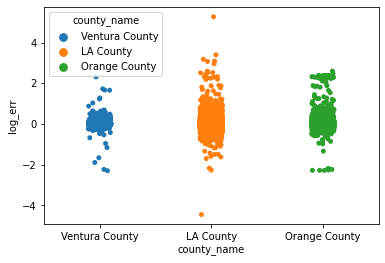

<AxesSubplot:xlabel='bldg_qual', ylabel='log_err'>

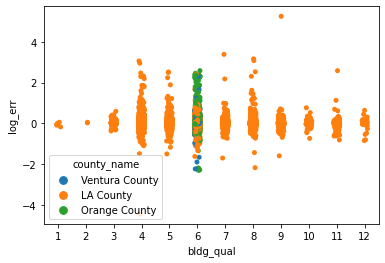

In [32]:
sns.stripplot(data= train, x='county_name', y='log_err', hue='county_name')
plt.show()
sns.stripplot(data= train, x='bldg_qual', y='log_err', hue='county_name')
plt.show()
sns.stripplot(data =train, x= 'has_pool', y='log_err', hue='county_name')
plt.show()
sns.stripplot(data =train, x= 'has_firepl', y='log_err', hue='county_name')
plt.show()
sns.stripplot(data =train, x= 'heat_sys_desc', y='log_err', hue='county_name')
plt.xticks(rotation='vertical')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Yes'),
  Text(1, 0, 'Central'),
  Text(2, 0, 'Floor/Wall'),
  Text(3, 0, 'Forced air'),
  Text(4, 0, 'Solar'),
  Text(5, 0, 'Baseboard'),
  Text(6, 0, 'None'),
  Text(7, 0, 'Radiant'),
  Text(8, 0, 'Gravity')])

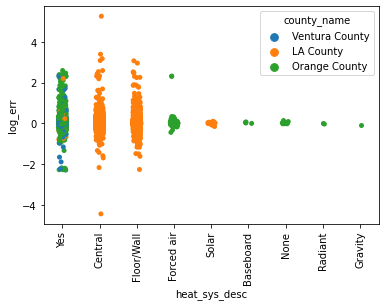

In [34]:
sns.stripplot(data =train, x= 'heat_sys_desc', y='log_err', hue='county_name')
plt.xticks(rotation='vertical')

Heating system types of interest: Central(2), Floor/Wall(7), and "Yes"(24)

In [ ]:
url = get_db_url('zillow')
pd.read_sql('SELECT * FROM heatingorsystemtype', url)

,heatingorsystemtypeid,heatingorsystemdesc
0,1,Baseboard
1,2,Central
2,3,Coal
3,4,Convection
4,5,Electric
5,6,Forced air
6,7,Floor/Wall
7,8,Gas
8,9,Geo Thermal
9,10,Gravity


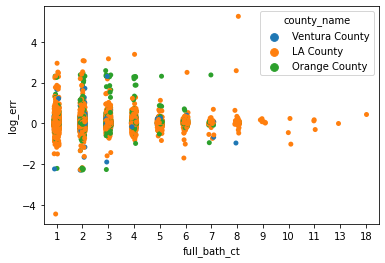

<AxesSubplot:xlabel='beds', ylabel='log_err'>

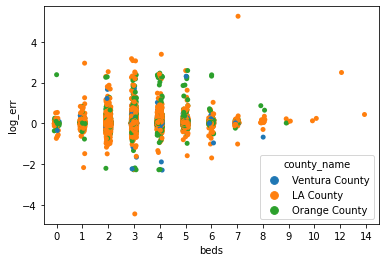

In [37]:
sns.stripplot(data= train, x='full_bath_ct', y='log_err', hue='county_name')
plt.show()
sns.stripplot(data= train, x='beds', y='log_err', hue='county_name')

### Continuous variables vs. log error

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40030 entries, 40146 to 40898
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            40030 non-null  int64  
 1   parcelid                      40030 non-null  int64  
 2   bathroomcnt                   40030 non-null  float64
 3   bedroomcnt                    40030 non-null  float64
 4   buildingqualitytypeid         40030 non-null  float64
 5   calculatedbathnbr             40030 non-null  float64
 6   calculatedfinishedsquarefeet  40030 non-null  float64
 7   finishedsquarefeet12          40030 non-null  float64
 8   fips                          40030 non-null  float64
 9   fullbathcnt                   40030 non-null  float64
 10  heatingorsystemtypeid         40030 non-null  float64
 11  latitude                      40030 non-null  float64
 12  longitude                     40030 non-null  float64
 1

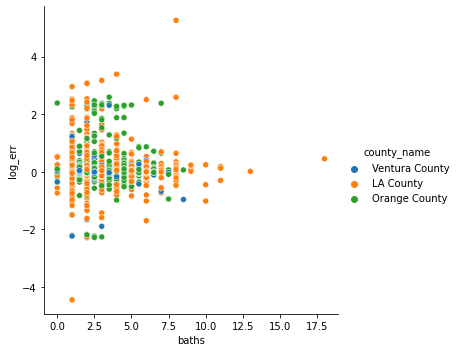

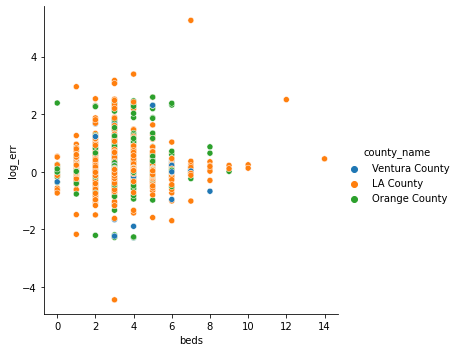

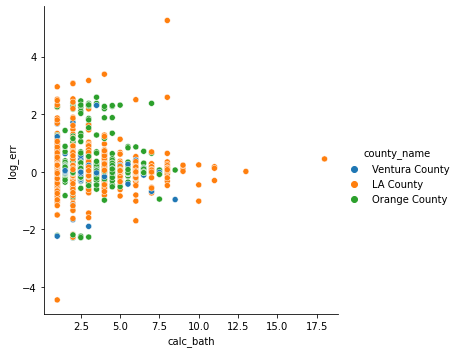

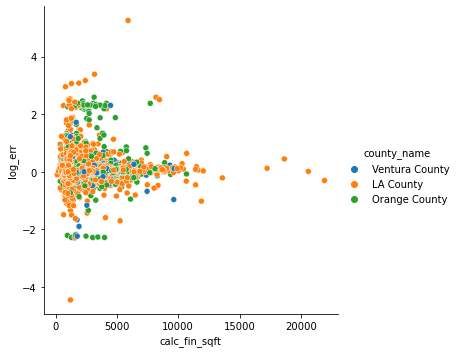

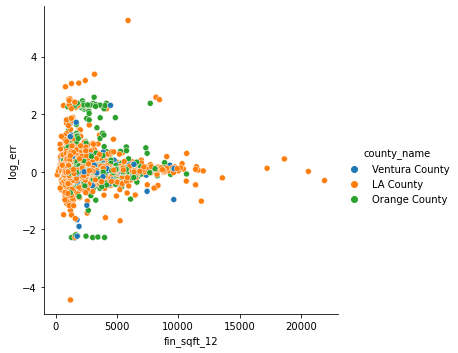

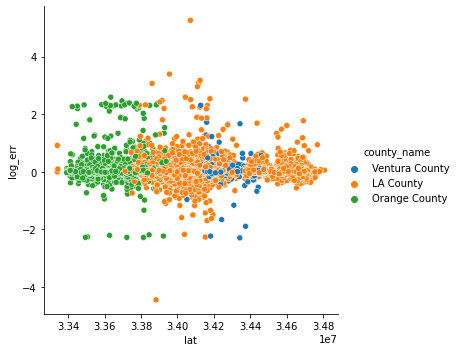

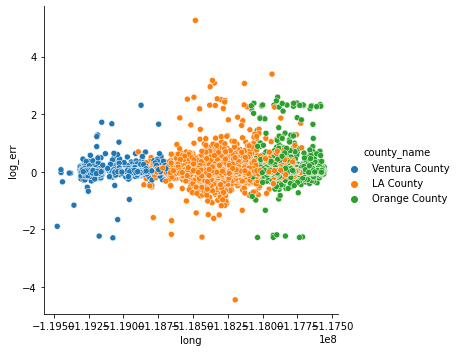

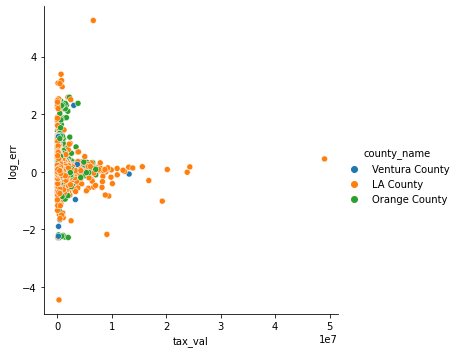

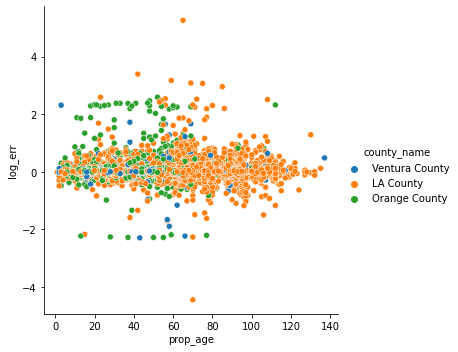

In [39]:
for var in cont_vars:
    sns.relplot(data=train, x=train[var],y='log_err', hue='county_name')
    plt.show()

### Takeaways: The lat and long variables show some pretty clear clustering patterns in visualizations that highlight the county in which the records were collected. 

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29240 entries, 47166 to 65169
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   parcel_id       29240 non-null  int64  
 1   baths           29240 non-null  float64
 2   beds            29240 non-null  int64  
 3   bldg_qual       29240 non-null  int64  
 4   calc_bath       29240 non-null  float64
 5   calc_fin_sqft   29240 non-null  float64
 6   fin_sqft_12     29240 non-null  float64
 7   county_code     29240 non-null  object 
 8   full_bath_ct    29240 non-null  int64  
 9   heat_sys        29240 non-null  int64  
 10  lat             29240 non-null  float64
 11  long            29240 non-null  float64
 12  has_pool        29240 non-null  uint8  
 13  zip             29240 non-null  int64  
 14  room_ct         29240 non-null  int64  
 15  unit_ct         29240 non-null  int64  
 16  has_firepl      29240 non-null  uint8  
 17  tax_val         29240 non-n

In [40]:
cols_to_scale = train.select_dtypes(include=(np.float64, np.int64)).columns.to_list()

train_scaled, validate_scaled, test_scaled = prep.minmax_scale_data(train, validate, test, cols_to_scale)

train_scaled.head()

,parcel_id,baths,beds,bldg_qual,calc_bath,calc_fin_sqft,fin_sqft_12,county_name,full_bath_ct,heat_sys,lat,long,has_pool,zip,room_ct,unit_ct,has_firepl,tax_val,log_err,heat_sys_desc,prop_land_desc,prop_age
47166,0.042146,0.138889,0.285714,0.454545,0.088235,0.099537,0.099537,Ventura County,0.058824,1.000000,0.599777,0.247543,0,0.003652,0.571429,0.0,0,0.006566,0.459715,Yes,Single Family Residential,0.286765
64175,0.014060,0.111111,0.214286,0.454545,0.058824,0.058346,0.058346,LA County,0.058824,0.043478,0.435117,0.831915,0,0.001679,0.000000,0.0,0,0.004865,0.452882,Central,Single Family Residential,0.308824
61285,0.008609,0.166667,0.214286,0.545455,0.117647,0.087198,0.087198,LA County,0.117647,0.043478,0.518852,0.565817,0,0.000224,0.000000,0.0,0,0.032289,0.465032,Central,Single Family Residential,0.382353
50075,0.005827,0.111111,0.214286,0.636364,0.058824,0.063483,0.063483,LA County,0.058824,0.043478,0.477388,0.565716,0,0.000109,0.000000,0.0,0,0.022759,0.443606,Central,Single Family Residential,0.507353
14064,0.023611,0.111111,0.214286,0.454545,0.058824,0.064722,0.064722,Orange County,0.058824,1.000000,0.236739,0.877126,0,0.003158,0.428571,0.0,0,0.010533,0.454173,Yes,Single Family Residential,0.286765


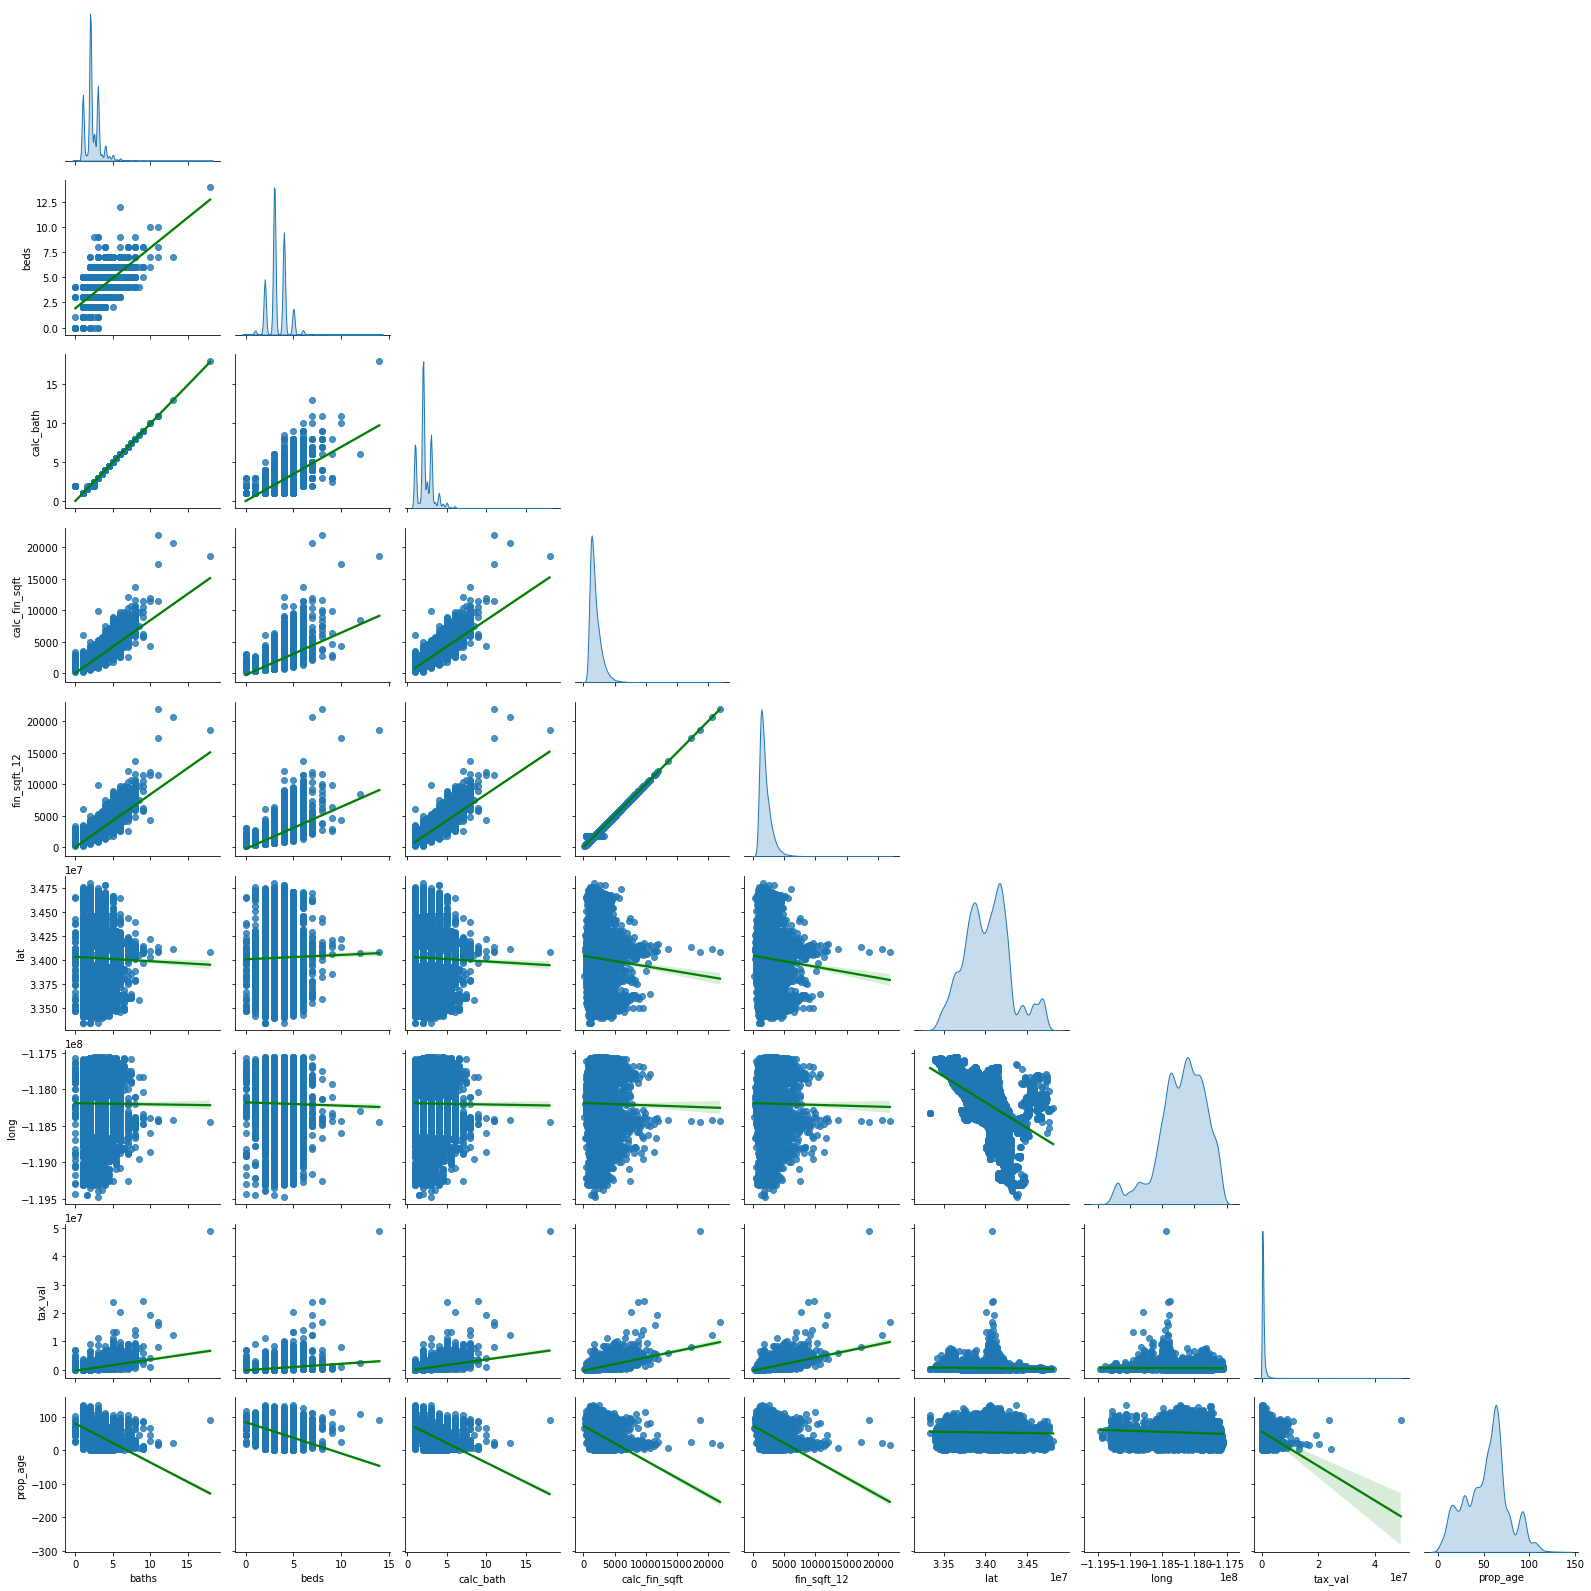

In [41]:
sns.pairplot(
    data= train[cont_vars], 
    kind='reg', 
    diag_kind='kde', 
    plot_kws= {'line_kws': {'color': 'green'}}, 
    corner=True, 
    dropna=True
    )

In [99]:
cont_vars

['baths',
 'beds',
 'calc_bath',
 'calc_fin_sqft',
 'fin_sqft_12',
 'lat',
 'long',
 'tax_val',
 'prop_age']

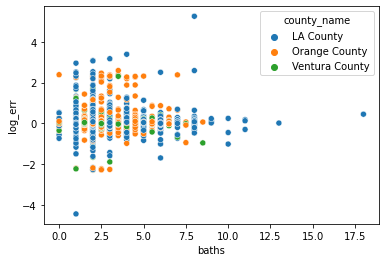

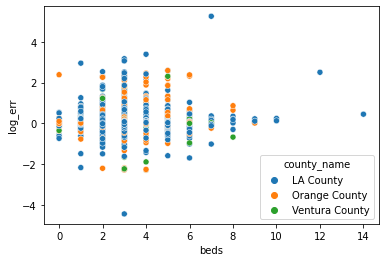

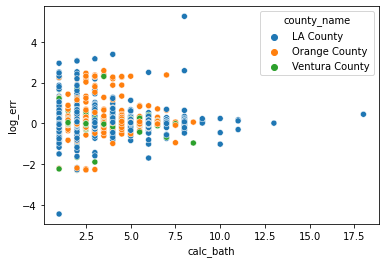

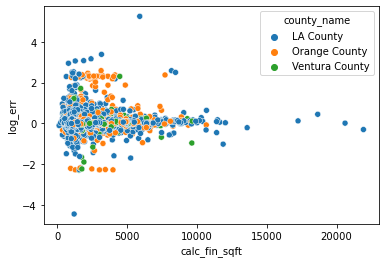

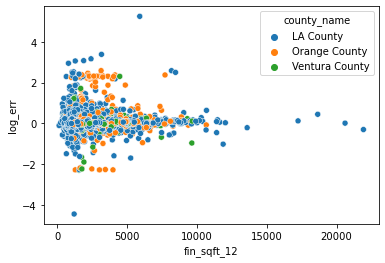

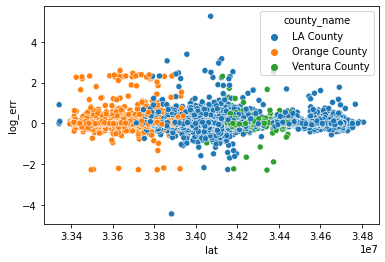

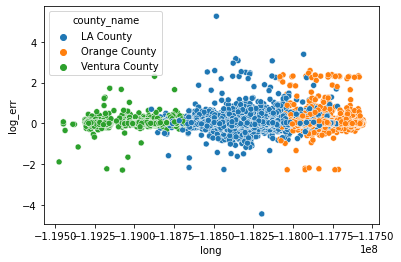

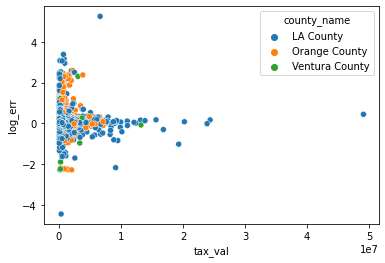

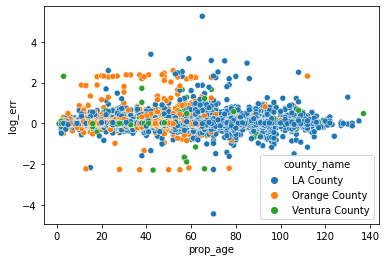

In [113]:
for var in cont_vars:
    sns.scatterplot(data=train, x=var, y='log_err', hue='county_name', hue_order=['LA County', 'Orange County', 'Ventura County'])
    plt.show()

### Is there a linear relationship between latitude (north-south movement) and log error?

$H_0:$ There is no linear relationship between latitude and log error.

$H_a:$ A linear relationship does exist between latitude and log error.

In [102]:
alpha = 0.05

r_coeff, pval = stats.pearsonr(train.lat, train.log_err)

if pval < alpha:
    print(f'The correlation strength is {r_coeff:.3f}, and our confidence level is {1-pval:.2%}. We can reject the null hypothesis.')
else:
    print(f'We fail to reject the null hypothesis. The confidence level of {1-alpha:.2%} was not met; confidence level for this test was {1-pval:.2%}.')



The correlation strength is -0.021, and our confidence level is 99.96%. We can reject the null hypothesis.


### There is a linear relationship between latitude and log error, but it is not very strong.

### Is there a linear relationship between longitude (east-west movement) and log error?

$H_0:$ There is no linear relationship between longitude and log error.

$H_a:$ A linear relationship does exist between longitude and log error.

In [103]:
r_coeff, pval = stats.pearsonr(train.long, train.log_err)

if pval < alpha:
    print(f'The correlation strength is {r_coeff:.3f}, and our confidence level is {1-pval:.2%}. We can reject the null hypothesis.')
else:
    print(f'We fail to reject the null hypothesis. The confidence level of {1-alpha:.2%} was not met; confidence level for this test was {1-pval:.2%}.')

The correlation strength is 0.025, and our confidence level is 100.00%. We can reject the null hypothesis.


### There is also a linear relationship between longitude and log error, and it is also not very strong.

In [105]:
train.columns

Index(['parcel_id', 'baths', 'beds', 'bldg_qual', 'calc_bath', 'calc_fin_sqft',
       'fin_sqft_12', 'county_name', 'full_bath_ct', 'heat_sys', 'lat', 'long',
       'has_pool', 'zip', 'room_ct', 'unit_ct', 'has_firepl', 'tax_val',
       'log_err', 'heat_sys_desc', 'prop_land_desc', 'prop_age', 'cluster_1',
       'cluster_2', 'mean_log_err', 'cluster_3', 'cluster_4', 'cluster_5',
       'cluster_6', 'cluster_7'],
      dtype='object')

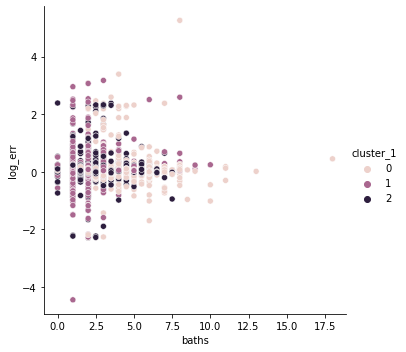

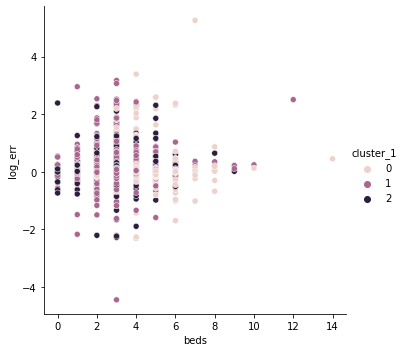

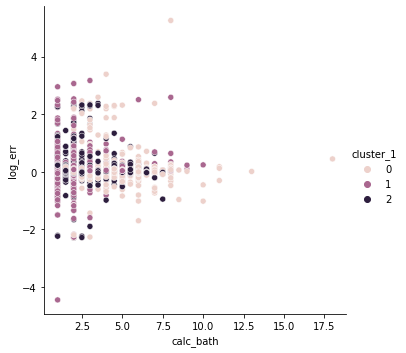

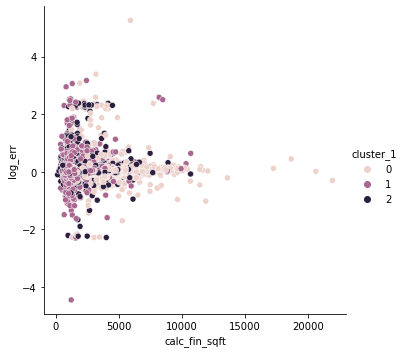

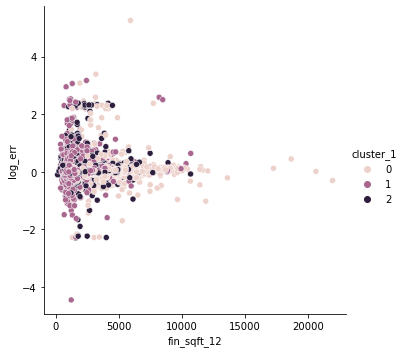

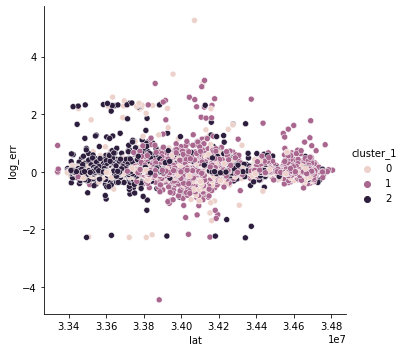

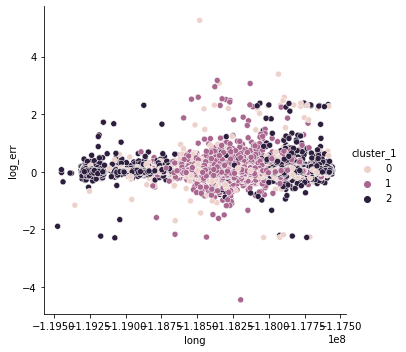

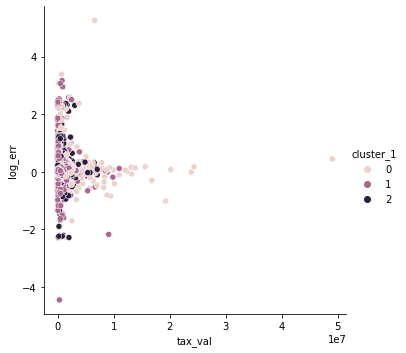

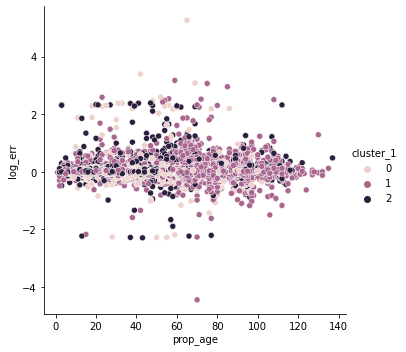

In [109]:
for var in cont_vars:
    sns.relplot(data=train, x=var, y='log_err', hue='cluster_1')
    plt.show()



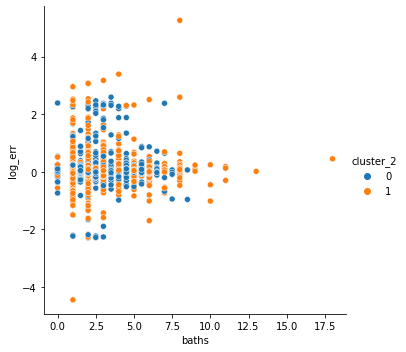

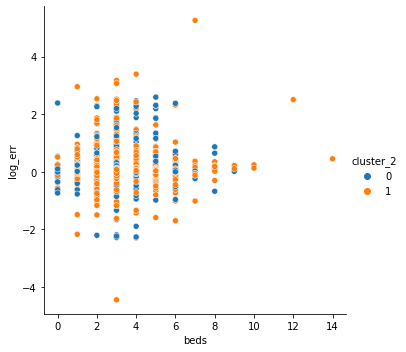

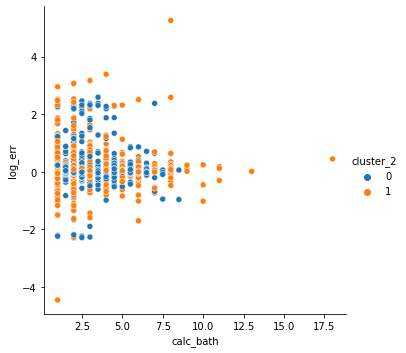

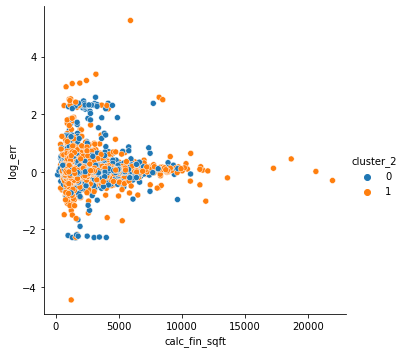

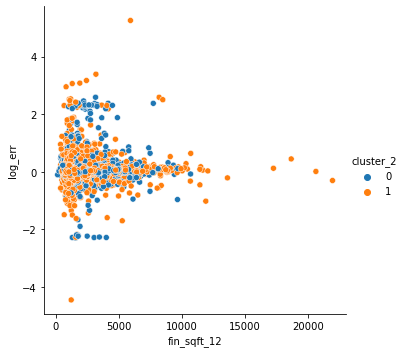

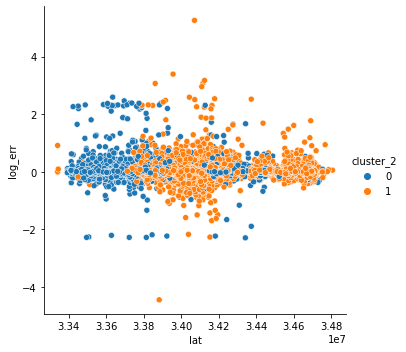

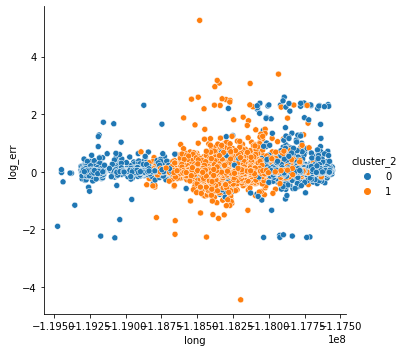

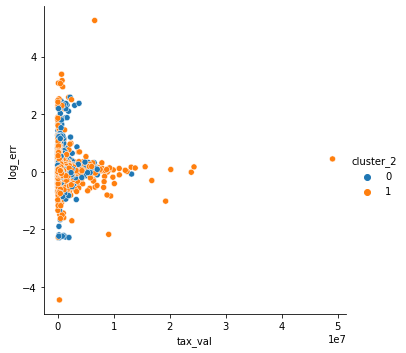

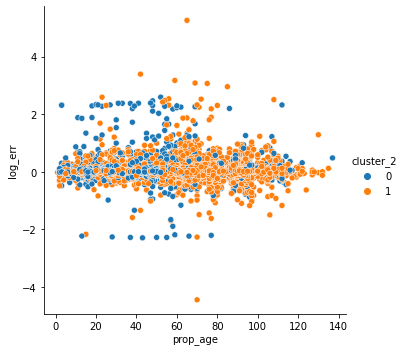

In [110]:
for var in cont_vars:
    sns.relplot(data=train, x=var, y='log_err', hue='cluster_2')
    plt.show()

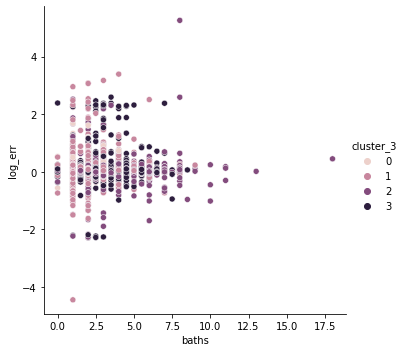

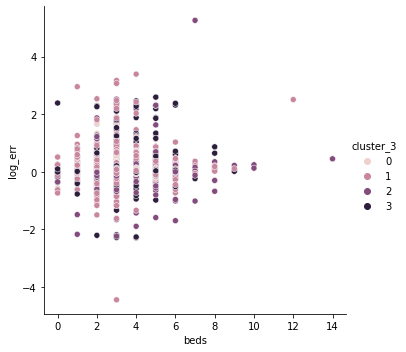

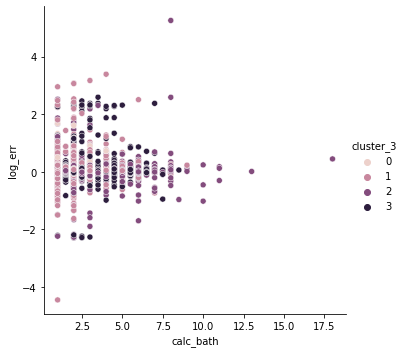

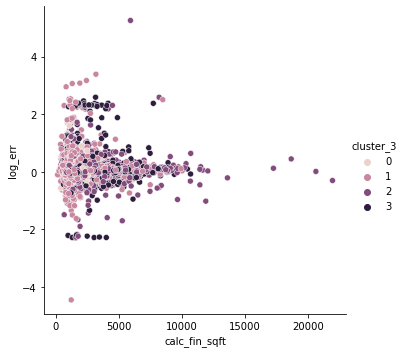

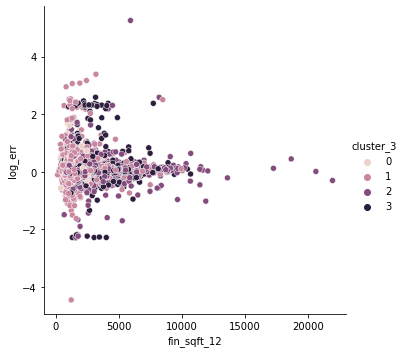

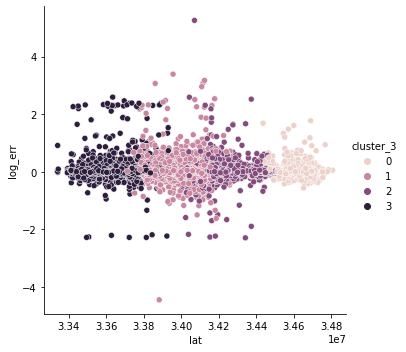

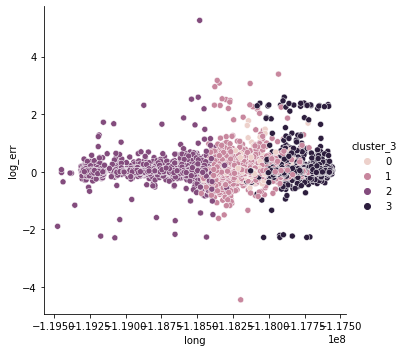

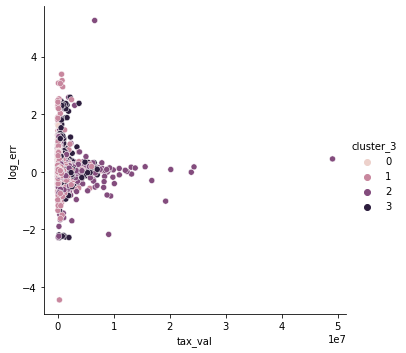

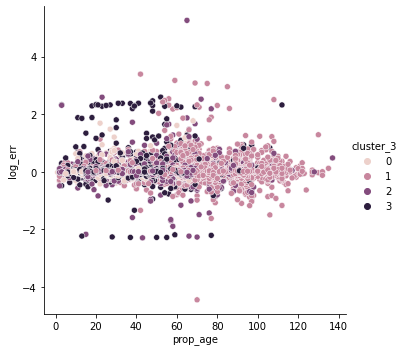

In [111]:
for var in cont_vars:
    sns.relplot(data=train, x=var, y='log_err', hue='cluster_3')
    plt.show()

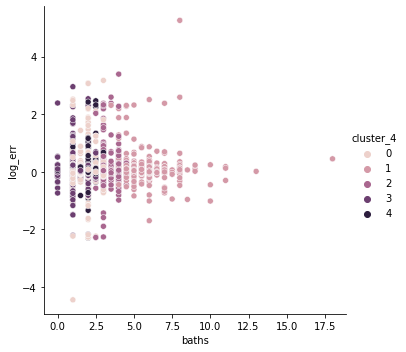

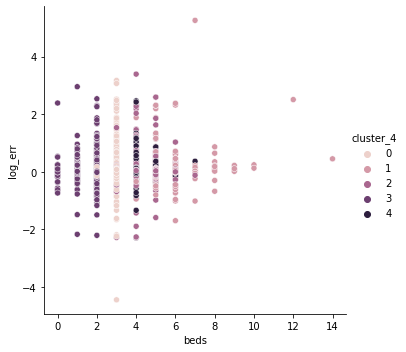

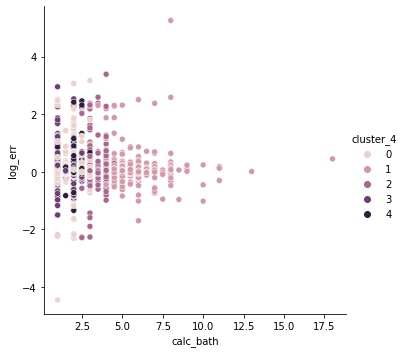

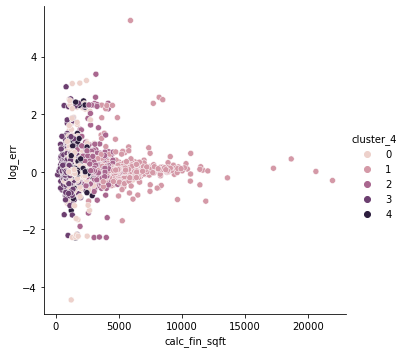

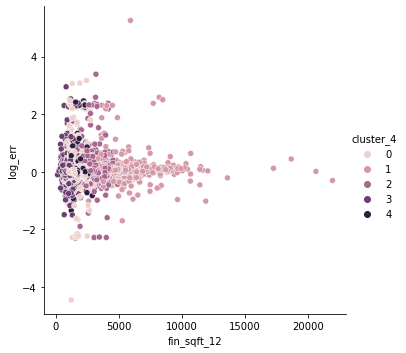

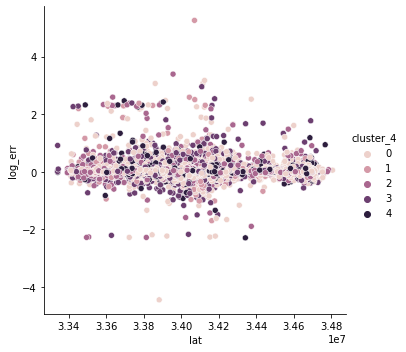

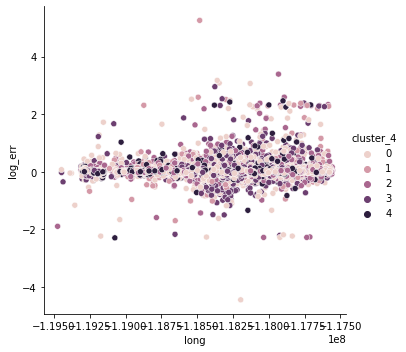

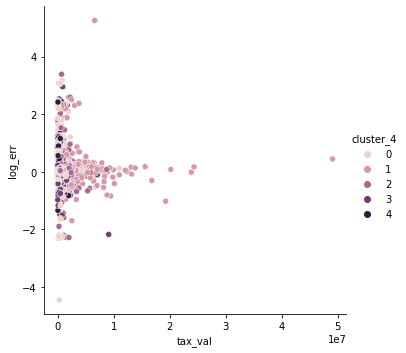

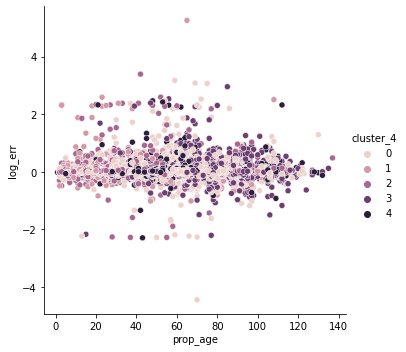

In [112]:
for var in cont_vars:
    sns.relplot(data=train, x=var, y='log_err', hue='cluster_4')
    plt.show()

In [42]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prep.isolate_lm_target(train, validate, test, 'log_err')

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29240 entries, 47166 to 65169
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   parcel_id       29240 non-null  int64  
 1   baths           29240 non-null  float64
 2   beds            29240 non-null  int64  
 3   bldg_qual       29240 non-null  int64  
 4   calc_bath       29240 non-null  float64
 5   calc_fin_sqft   29240 non-null  float64
 6   fin_sqft_12     29240 non-null  float64
 7   county_name     29240 non-null  object 
 8   full_bath_ct    29240 non-null  int64  
 9   heat_sys        29240 non-null  int64  
 10  lat             29240 non-null  float64
 11  long            29240 non-null  float64
 12  has_pool        29240 non-null  uint8  
 13  zip             29240 non-null  int64  
 14  room_ct         29240 non-null  int64  
 15  unit_ct         29240 non-null  int64  
 16  has_firepl      29240 non-null  uint8  
 17  tax_val         29240 non-n

In [114]:
X_tr_scaled, _, X_val_scaled, _, X_test_scaled, _ = prep.isolate_lm_target(train_scaled, validate_scaled, test_scaled, 'log_err')

X_tr_scaled.head()

,parcel_id,baths,beds,bldg_qual,calc_bath,calc_fin_sqft,fin_sqft_12,county_name,full_bath_ct,heat_sys,lat,long,has_pool,zip,room_ct,unit_ct,has_firepl,tax_val,heat_sys_desc,prop_land_desc,prop_age
47166,0.042146,0.138889,0.285714,0.454545,0.088235,0.099537,0.099537,Ventura County,0.058824,1.000000,0.599777,0.247543,0,0.003652,0.571429,0.0,0,0.006566,Yes,Single Family Residential,0.286765
64175,0.014060,0.111111,0.214286,0.454545,0.058824,0.058346,0.058346,LA County,0.058824,0.043478,0.435117,0.831915,0,0.001679,0.000000,0.0,0,0.004865,Central,Single Family Residential,0.308824
61285,0.008609,0.166667,0.214286,0.545455,0.117647,0.087198,0.087198,LA County,0.117647,0.043478,0.518852,0.565817,0,0.000224,0.000000,0.0,0,0.032289,Central,Single Family Residential,0.382353
50075,0.005827,0.111111,0.214286,0.636364,0.058824,0.063483,0.063483,LA County,0.058824,0.043478,0.477388,0.565716,0,0.000109,0.000000,0.0,0,0.022759,Central,Single Family Residential,0.507353
14064,0.023611,0.111111,0.214286,0.454545,0.058824,0.064722,0.064722,Orange County,0.058824,1.000000,0.236739,0.877126,0,0.003158,0.428571,0.0,0,0.010533,Yes,Single Family Residential,0.286765


In [44]:
X_tr_scaled = X_tr_scaled.select_dtypes(include=np.number)
X_val_scaled = X_val_scaled.select_dtypes(include=np.number)
X_test_scaled = X_test_scaled.select_dtypes(include=np.number)

X_tr_scaled.drop(columns= ['parcel_id'], inplace=True)
X_val_scaled.drop(columns= ['parcel_id'], inplace=True)
X_test_scaled.drop(columns= ['parcel_id'], inplace=True)

X_tr_scaled.drop(columns= ['tax_val'], inplace=True)
X_val_scaled.drop(columns= ['tax_val'], inplace=True)
X_test_scaled.drop(columns= ['tax_val'], inplace=True)

X_tr_scaled.columns

Index(['baths', 'beds', 'bldg_qual', 'calc_bath', 'calc_fin_sqft',
       'fin_sqft_12', 'full_bath_ct', 'heat_sys', 'lat', 'long', 'has_pool',
       'zip', 'room_ct', 'unit_ct', 'has_firepl', 'tax_val', 'prop_age'],
      dtype='object')

In [45]:
X_tr_scaled.drop(columns= ['tax_val'], inplace=True)
X_val_scaled.drop(columns= ['tax_val'], inplace=True)
X_test_scaled.drop(columns= ['tax_val'], inplace=True)

X_tr_scaled.columns

Index(['baths', 'beds', 'bldg_qual', 'calc_bath', 'calc_fin_sqft',
       'fin_sqft_12', 'full_bath_ct', 'heat_sys', 'lat', 'long', 'has_pool',
       'zip', 'room_ct', 'unit_ct', 'has_firepl', 'prop_age'],
      dtype='object')

In [47]:
kmeans = KMeans(n_clusters=3)

kmeans.fit(X_tr_scaled)

train['cluster_1'] = kmeans.predict(X_tr_scaled)

train.head()

,parcel_id,baths,beds,bldg_qual,calc_bath,calc_fin_sqft,fin_sqft_12,county_name,full_bath_ct,heat_sys,lat,long,has_pool,zip,room_ct,unit_ct,has_firepl,tax_val,log_err,heat_sys_desc,prop_land_desc,prop_age,cluster_1
47166,17128504,2.5,4,6,2.5,2298.0,2298.0,Ventura County,2,24,34220094.0,-119000009.0,0,97091,8,1,0,325368.0,0.013072,Yes,Single Family Residential,40,2
64175,12852432,2.0,3,6,2.0,1400.0,1400.0,LA County,2,2,33978648.0,-117878079.0,0,96492,0,1,0,241917.0,-0.053325,Central,Single Family Residential,43,1
61285,12022559,3.0,3,7,3.0,2029.0,2029.0,LA County,3,2,34101431.0,-118388957.0,0,96050,0,1,0,1587306.0,0.064735,Central,Single Family Residential,53,1
50075,11599053,2.0,3,8,2.0,1512.0,1512.0,LA County,2,2,34040630.0,-118389152.0,0,96015,0,1,0,1119770.0,-0.143460,Central,Single Family Residential,70,1
14064,14306587,2.0,3,6,2.0,1539.0,1539.0,Orange County,2,24,33687758.0,-117791277.0,0,96941,6,1,0,519967.0,-0.040782,Yes,Single Family Residential,40,2


<AxesSubplot:xlabel='county_name', ylabel='log_err'>

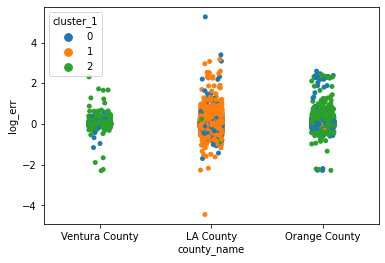

In [50]:
sns.stripplot(data=train, x='county_name', y='log_err', hue='cluster_1')



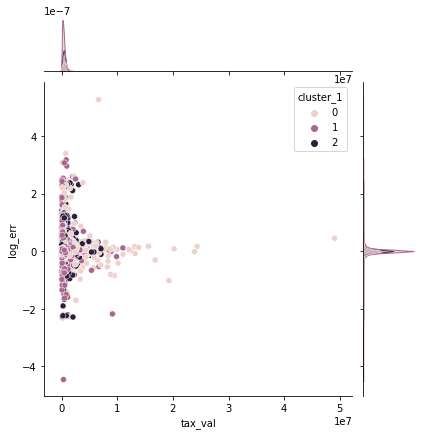

In [59]:
sns.jointplot(data=train, x='tax_val', y='log_err', hue='cluster_1')

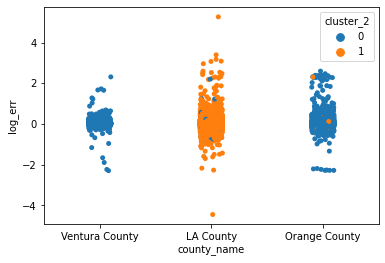

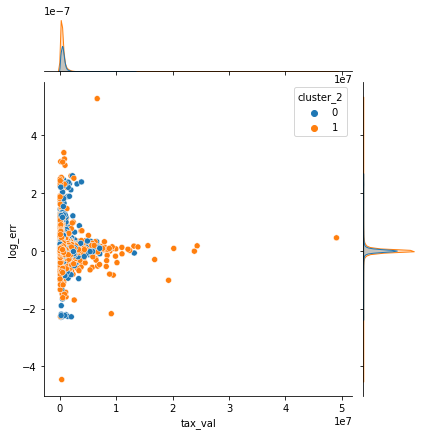

In [62]:
kmeans = KMeans(n_clusters=2).fit(X_tr_scaled)

train['cluster_2'] = kmeans.predict(X_tr_scaled)

sns.stripplot(data=train, x='county_name', y='log_err', hue='cluster_2')
plt.show()
sns.jointplot(data=train, x='tax_val', y='log_err', hue='cluster_2')

In [63]:
kmeans = KMeans(n_clusters=4).fit(X_tr_scaled[['lat', 'long', 'calc_fin_sqft', 'calc_bath']])

train['mean_log_err'] = train.log_err.mean()
train['cluster_4'] = kmeans.predict(X_tr_scaled[['lat', 'long', 'calc_fin_sqft', 'calc_bath']])

train.head()

,parcel_id,baths,beds,bldg_qual,calc_bath,calc_fin_sqft,fin_sqft_12,county_name,full_bath_ct,heat_sys,lat,long,has_pool,zip,room_ct,unit_ct,has_firepl,tax_val,log_err,heat_sys_desc,prop_land_desc,prop_age,cluster_1,cluster_2,mean_log_err,cluster_4
47166,17128504,2.5,4,6,2.5,2298.0,2298.0,Ventura County,2,24,34220094.0,-119000009.0,0,97091,8,1,0,325368.0,0.013072,Yes,Single Family Residential,40,2,0,0.018728,2
64175,12852432,2.0,3,6,2.0,1400.0,1400.0,LA County,2,2,33978648.0,-117878079.0,0,96492,0,1,0,241917.0,-0.053325,Central,Single Family Residential,43,1,1,0.018728,1
61285,12022559,3.0,3,7,3.0,2029.0,2029.0,LA County,3,2,34101431.0,-118388957.0,0,96050,0,1,0,1587306.0,0.064735,Central,Single Family Residential,53,1,1,0.018728,1
50075,11599053,2.0,3,8,2.0,1512.0,1512.0,LA County,2,2,34040630.0,-118389152.0,0,96015,0,1,0,1119770.0,-0.143460,Central,Single Family Residential,70,1,1,0.018728,1
14064,14306587,2.0,3,6,2.0,1539.0,1539.0,Orange County,2,24,33687758.0,-117791277.0,0,96941,6,1,0,519967.0,-0.040782,Yes,Single Family Residential,40,2,0,0.018728,3


In [64]:
train.rename(columns={'cluster_4':'cluster_3'}, inplace=True)

train.head()

,parcel_id,baths,beds,bldg_qual,calc_bath,calc_fin_sqft,fin_sqft_12,county_name,full_bath_ct,heat_sys,lat,long,has_pool,zip,room_ct,unit_ct,has_firepl,tax_val,log_err,heat_sys_desc,prop_land_desc,prop_age,cluster_1,cluster_2,mean_log_err,cluster_3
47166,17128504,2.5,4,6,2.5,2298.0,2298.0,Ventura County,2,24,34220094.0,-119000009.0,0,97091,8,1,0,325368.0,0.013072,Yes,Single Family Residential,40,2,0,0.018728,2
64175,12852432,2.0,3,6,2.0,1400.0,1400.0,LA County,2,2,33978648.0,-117878079.0,0,96492,0,1,0,241917.0,-0.053325,Central,Single Family Residential,43,1,1,0.018728,1
61285,12022559,3.0,3,7,3.0,2029.0,2029.0,LA County,3,2,34101431.0,-118388957.0,0,96050,0,1,0,1587306.0,0.064735,Central,Single Family Residential,53,1,1,0.018728,1
50075,11599053,2.0,3,8,2.0,1512.0,1512.0,LA County,2,2,34040630.0,-118389152.0,0,96015,0,1,0,1119770.0,-0.143460,Central,Single Family Residential,70,1,1,0.018728,1
14064,14306587,2.0,3,6,2.0,1539.0,1539.0,Orange County,2,24,33687758.0,-117791277.0,0,96941,6,1,0,519967.0,-0.040782,Yes,Single Family Residential,40,2,0,0.018728,3


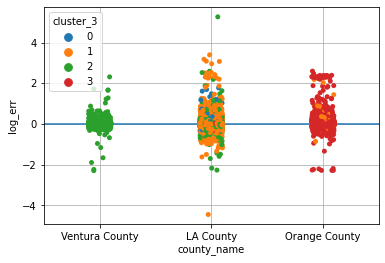

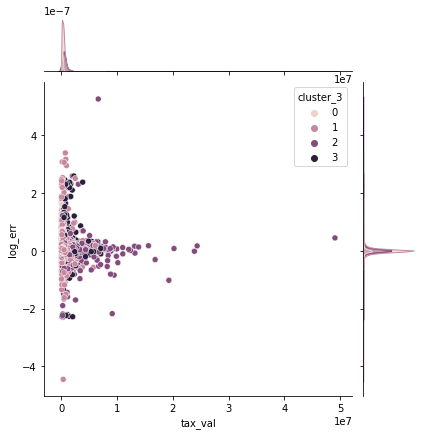

In [65]:
ax = sns.stripplot(data=train, x='county_name', y='log_err', hue='cluster_3')
ax.axhline(train.mean_log_err.mean())
ax.grid()
plt.show()
sns.jointplot(data=train, x='tax_val', y='log_err', hue='cluster_3')


In [66]:
def cluster_plucker(df, scaled_df, k):
    kmeans = KMeans(n_clusters=k).fit(scaled_df)
    df['cluster_'] = kmeans.predict(scaled_df)
    return df 


cluster_plucker(train, X_tr_scaled[['beds', 'baths', 'calc_fin_sqft']], 5)

train.rename(columns= {'cluster_': 'cluster_4'}, inplace=True)
train.head()

,parcel_id,baths,beds,bldg_qual,calc_bath,calc_fin_sqft,fin_sqft_12,county_name,full_bath_ct,heat_sys,lat,long,has_pool,zip,room_ct,unit_ct,has_firepl,tax_val,log_err,heat_sys_desc,prop_land_desc,prop_age,cluster_1,cluster_2,mean_log_err,cluster_3,cluster_4
47166,17128504,2.5,4,6,2.5,2298.0,2298.0,Ventura County,2,24,34220094.0,-119000009.0,0,97091,8,1,0,325368.0,0.013072,Yes,Single Family Residential,40,2,0,0.018728,2,4
64175,12852432,2.0,3,6,2.0,1400.0,1400.0,LA County,2,2,33978648.0,-117878079.0,0,96492,0,1,0,241917.0,-0.053325,Central,Single Family Residential,43,1,1,0.018728,1,0
61285,12022559,3.0,3,7,3.0,2029.0,2029.0,LA County,3,2,34101431.0,-118388957.0,0,96050,0,1,0,1587306.0,0.064735,Central,Single Family Residential,53,1,1,0.018728,1,0
50075,11599053,2.0,3,8,2.0,1512.0,1512.0,LA County,2,2,34040630.0,-118389152.0,0,96015,0,1,0,1119770.0,-0.143460,Central,Single Family Residential,70,1,1,0.018728,1,0
14064,14306587,2.0,3,6,2.0,1539.0,1539.0,Orange County,2,24,33687758.0,-117791277.0,0,96941,6,1,0,519967.0,-0.040782,Yes,Single Family Residential,40,2,0,0.018728,3,0


<AxesSubplot:xlabel='county_name', ylabel='log_err'>

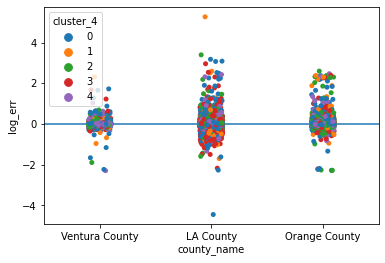

In [68]:
def viz_cluster(df, x, y, hue, hline=False):
    graph = sns.stripplot(data=df, x=x,y=y, hue=hue)

    if hline:
        graph.axhline(hline)
        return graph
    else:
        return graph

viz_cluster(train, train.county_name, train.log_err, train.cluster_4, train.mean_log_err.mean())

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Yes'),
  Text(1, 0, 'Central'),
  Text(2, 0, 'Floor/Wall'),
  Text(3, 0, 'Forced air'),
  Text(4, 0, 'Solar'),
  Text(5, 0, 'Baseboard'),
  Text(6, 0, 'None'),
  Text(7, 0, 'Radiant'),
  Text(8, 0, 'Gravity')])

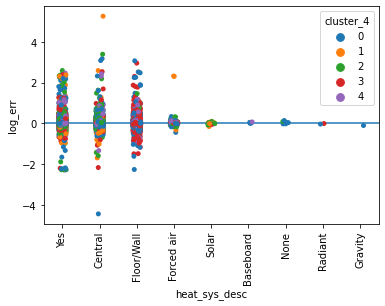

In [69]:
ax = sns.stripplot(data=train, x='heat_sys_desc', y='log_err', hue='cluster_4')
ax.axhline(train.log_err.mean())
plt.xticks(rotation=90)

In [71]:
f_feature = prep.select_kbest(X_train[X_tr_scaled.columns], y_train, 4)

f_feature

['beds', 'calc_bath', 'calc_fin_sqft', 'fin_sqft_12']

In [72]:
cluster_plucker(train, X_tr_scaled[f_feature], 3)

,parcel_id,baths,beds,bldg_qual,calc_bath,calc_fin_sqft,fin_sqft_12,county_name,full_bath_ct,heat_sys,lat,long,has_pool,zip,room_ct,unit_ct,has_firepl,tax_val,log_err,heat_sys_desc,prop_land_desc,prop_age,cluster_1,cluster_2,mean_log_err,cluster_3,cluster_4,cluster_
47166,17128504,2.5,4,6,2.5,2298.0,2298.0,Ventura County,2,24,34220094.0,-119000009.0,0,97091,8,1,0,325368.0,0.013072,Yes,Single Family Residential,40,2,0,0.018728,2,4,0
64175,12852432,2.0,3,6,2.0,1400.0,1400.0,LA County,2,2,33978648.0,-117878079.0,0,96492,0,1,0,241917.0,-0.053325,Central,Single Family Residential,43,1,1,0.018728,1,0,1
61285,12022559,3.0,3,7,3.0,2029.0,2029.0,LA County,3,2,34101431.0,-118388957.0,0,96050,0,1,0,1587306.0,0.064735,Central,Single Family Residential,53,1,1,0.018728,1,0,0
50075,11599053,2.0,3,8,2.0,1512.0,1512.0,LA County,2,2,34040630.0,-118389152.0,0,96015,0,1,0,1119770.0,-0.143460,Central,Single Family Residential,70,1,1,0.018728,1,0,1
14064,14306587,2.0,3,6,2.0,1539.0,1539.0,Orange County,2,24,33687758.0,-117791277.0,0,96941,6,1,0,519967.0,-0.040782,Yes,Single Family Residential,40,2,0,0.018728,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23589,12833927,1.0,3,4,1.0,1020.0,1020.0,LA County,1,7,33998458.0,-117954741.0,0,96489,0,1,0,43026.0,-0.003045,Floor/Wall,Single Family Residential,62,1,1,0.018728,1,0,1
38408,14472857,2.0,4,6,2.0,1690.0,1690.0,Orange County,2,24,33602663.0,-117668635.0,1,96995,6,1,0,645000.0,-0.022526,Yes,Single Family Residential,52,0,0,0.018728,3,4,0
42078,11959990,1.0,3,4,1.0,1497.0,1497.0,LA County,1,2,34109080.0,-118240011.0,0,96046,0,1,0,671289.0,-0.053819,Central,Single Family Residential,106,1,1,0.018728,1,0,1
42989,12707972,2.0,3,8,2.0,1442.0,1442.0,LA County,2,2,33780618.0,-118384524.0,0,96122,0,1,0,95836.0,0.078676,Central,Single Family Residential,58,1,1,0.018728,1,0,1


In [73]:
train.rename(columns= {'cluster_': 'cluster_5'}, inplace=True)

train.head()

,parcel_id,baths,beds,bldg_qual,calc_bath,calc_fin_sqft,fin_sqft_12,county_name,full_bath_ct,heat_sys,lat,long,has_pool,zip,room_ct,unit_ct,has_firepl,tax_val,log_err,heat_sys_desc,prop_land_desc,prop_age,cluster_1,cluster_2,mean_log_err,cluster_3,cluster_4,cluster_5
47166,17128504,2.5,4,6,2.5,2298.0,2298.0,Ventura County,2,24,34220094.0,-119000009.0,0,97091,8,1,0,325368.0,0.013072,Yes,Single Family Residential,40,2,0,0.018728,2,4,0
64175,12852432,2.0,3,6,2.0,1400.0,1400.0,LA County,2,2,33978648.0,-117878079.0,0,96492,0,1,0,241917.0,-0.053325,Central,Single Family Residential,43,1,1,0.018728,1,0,1
61285,12022559,3.0,3,7,3.0,2029.0,2029.0,LA County,3,2,34101431.0,-118388957.0,0,96050,0,1,0,1587306.0,0.064735,Central,Single Family Residential,53,1,1,0.018728,1,0,0
50075,11599053,2.0,3,8,2.0,1512.0,1512.0,LA County,2,2,34040630.0,-118389152.0,0,96015,0,1,0,1119770.0,-0.143460,Central,Single Family Residential,70,1,1,0.018728,1,0,1
14064,14306587,2.0,3,6,2.0,1539.0,1539.0,Orange County,2,24,33687758.0,-117791277.0,0,96941,6,1,0,519967.0,-0.040782,Yes,Single Family Residential,40,2,0,0.018728,3,0,1


Median Log Error: 0.007043581321395
Mean Log Error: 0.018728456349385438


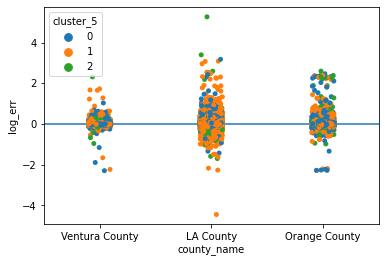

In [74]:
viz_cluster(train, 'county_name', 'log_err', 'cluster_5', train.log_err.median())

print(f'Median Log Error: {train.log_err.median()}\nMean Log Error: {train.log_err.mean()}')

In [75]:
rfe_feature, rfe_ranked = prep.rfe(X_train[X_tr_scaled.columns], y_train, 3)

rfe_ranked

,Var,Rank
0,baths,1
1,beds,3
2,bldg_qual,5
3,calc_bath,1
4,calc_fin_sqft,11
5,fin_sqft_12,10
6,full_bath_ct,7
7,heat_sys,8
8,lat,14
9,long,13


In [76]:
cluster_plucker(train, X_tr_scaled[rfe_feature], 3)

train.head()

,parcel_id,baths,beds,bldg_qual,calc_bath,calc_fin_sqft,fin_sqft_12,county_name,full_bath_ct,heat_sys,lat,long,has_pool,zip,room_ct,unit_ct,has_firepl,tax_val,log_err,heat_sys_desc,prop_land_desc,prop_age,cluster_1,cluster_2,mean_log_err,cluster_3,cluster_4,cluster_5,cluster_
47166,17128504,2.5,4,6,2.5,2298.0,2298.0,Ventura County,2,24,34220094.0,-119000009.0,0,97091,8,1,0,325368.0,0.013072,Yes,Single Family Residential,40,2,0,0.018728,2,4,0,2
64175,12852432,2.0,3,6,2.0,1400.0,1400.0,LA County,2,2,33978648.0,-117878079.0,0,96492,0,1,0,241917.0,-0.053325,Central,Single Family Residential,43,1,1,0.018728,1,0,1,0
61285,12022559,3.0,3,7,3.0,2029.0,2029.0,LA County,3,2,34101431.0,-118388957.0,0,96050,0,1,0,1587306.0,0.064735,Central,Single Family Residential,53,1,1,0.018728,1,0,0,2
50075,11599053,2.0,3,8,2.0,1512.0,1512.0,LA County,2,2,34040630.0,-118389152.0,0,96015,0,1,0,1119770.0,-0.143460,Central,Single Family Residential,70,1,1,0.018728,1,0,1,0
14064,14306587,2.0,3,6,2.0,1539.0,1539.0,Orange County,2,24,33687758.0,-117791277.0,0,96941,6,1,0,519967.0,-0.040782,Yes,Single Family Residential,40,2,0,0.018728,3,0,1,0


In [77]:
train.unit_ct.value_counts()

1    29226
2       14
Name: unit_ct, dtype: int64

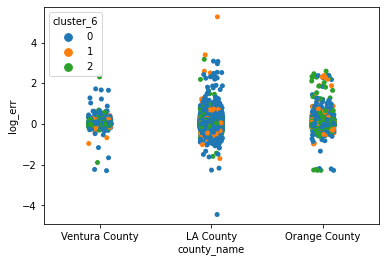

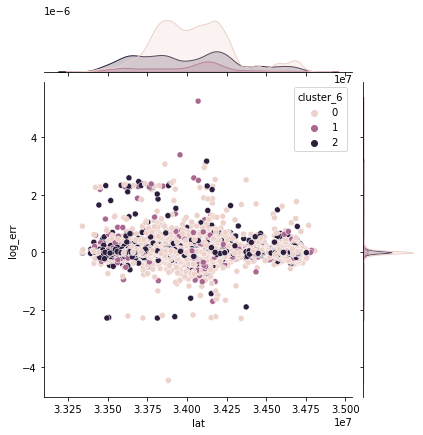

In [98]:
train.rename(columns= {'cluster_': 'cluster_6'}, inplace=True)

viz_cluster(train, 'county_name', 'log_err', 'cluster_6')
plt.show()
sns.jointplot(data=train, x='lat', y='log_err', hue='cluster_6')


<AxesSubplot:xlabel='county_name', ylabel='log_err'>

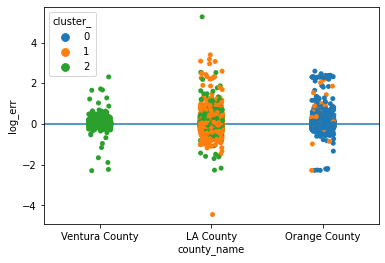

In [80]:
cluster_plucker(train, X_tr_scaled[['lat', 'long']], 3)
viz_cluster(train, 'county_name', 'log_err', 'cluster_', train.log_err.mean())

In [82]:
train.head()

train.rename(columns= {'cluster_': 'cluster_7'}, inplace=True)

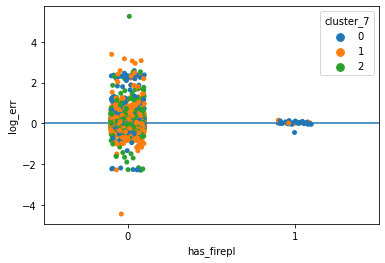

<AxesSubplot:xlabel='has_pool', ylabel='log_err'>

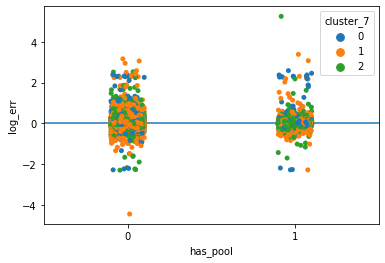

In [83]:
viz_cluster(train, 'has_firepl', 'log_err', 'cluster_7', train.log_err.mean())
plt.show()
viz_cluster(train, 'has_pool', 'log_err', 'cluster_7', train.log_err.mean())

<AxesSubplot:>

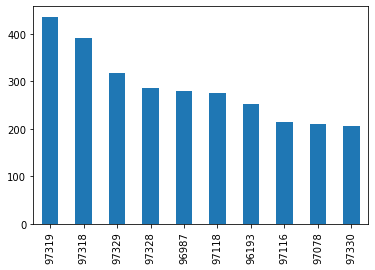

In [84]:
train.zip.value_counts().head(10).plot.bar()

In [85]:
cluster_1 = pd.DataFrame(train.cluster_1.value_counts().sort_index())
cluster_2 = pd.DataFrame(train.cluster_2.value_counts().sort_index())
cluster_3 = pd.DataFrame(train.cluster_3.value_counts().sort_index())
cluster_4 = pd.DataFrame(train.cluster_4.value_counts().sort_index())
cluster_5 = pd.DataFrame(train.cluster_5.value_counts().sort_index())
cluster_6 = pd.DataFrame(train.cluster_6.value_counts().sort_index())
cluster_7 = pd.DataFrame(train.cluster_7.value_counts().sort_index())

,cluster_7
0,6826
1,13014
2,9400


# Regression Models based on cluster findings

In [93]:
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

lr1 = LinearRegression()
lr1.fit(X_tr_scaled, y_train)

y_train['med_bl'] = y_train.log_err.median()
y_train['mean_bl'] = y_train.log_err.mean()
y_train['yhat'] = lr1.predict(X_tr_scaled)
y_train.head()

y_train.head()

,log_err,med_bl,mean_bl,yhat
47166,0.013072,0.007044,0.018728,0.018626
64175,-0.053325,0.007044,0.018728,0.018245
61285,0.064735,0.007044,0.018728,0.016714
50075,-0.143460,0.007044,0.018728,0.006256
14064,-0.040782,0.007044,0.018728,0.023448


In [94]:
y_train.rename(columns= {'yhat': 'yhat_1'}, inplace=True)

y_train.head()

,log_err,med_bl,mean_bl,yhat_1
47166,0.013072,0.007044,0.018728,0.018626
64175,-0.053325,0.007044,0.018728,0.018245
61285,0.064735,0.007044,0.018728,0.016714
50075,-0.143460,0.007044,0.018728,0.006256
14064,-0.040782,0.007044,0.018728,0.023448


In [ ]:
def pipe_fitter(X_scaled, y):
    '''
    Takes in a scaled, isolated train/validate/test split and a target df, fits them to an OLS model, and 
    returns the target df with a column of predictions(['yhat_']) from the model.'''
    lr = LinearRegression()
    lr.fit(X_scaled, y)
    y['yhat_'] = lr.predict(X_scaled)
    return y


In [87]:
from sklearn.metrics import mean_squared_error
from evaluate import get_rmse

med_bl_rmse = get_rmse(y_train.log_err, y_train.med_bl)
mean_bl_rmse = get_rmse(y_train.log_err, y_train.mean_bl)
model_1_rmse = get_rmse(y_train.log_err, y_train.yhat)

print(f'Median-BL RMSE: {med_bl_rmse:.3f}\nMean-BL RMSE: {mean_bl_rmse:.3f}\nModel 1 RMSE: {model_1_rmse:.3f}')

Median-BL RMSE: 0.179
Mean-BL RMSE: 0.178
Model 1 RMSE: 0.178


In [ ]:
len(train.cluster_1)

29240

In [88]:
fuster_cluckers = [
    train.cluster_1,
    train.cluster_2,
    train.cluster_3,
    train.cluster_4,
    train.cluster_5,
    train.cluster_6,
    train.cluster_7
]

for cluck in fuster_cluckers:
    print(len(cluck))

print('------------')
print(len(X_tr_scaled))

29240
29240
29240
29240
29240
29240
29240
------------
29240


In [97]:
for cluck in fuster_cluckers:
    print(f'{cluck}\n--------')

cluster_1
--------
cluster_2
--------
cluster_3
--------
cluster_4
--------
cluster_5
--------
cluster_6
--------
cluster_7
--------
